# Tree crown delineation using detectreeRGB

{bdg-primary}`Forest`
{bdg-secondary}`Modelling`
{bdg-warning}`Standard`
{bdg-info}`Python`

<p align="left">
    <a href="https://github.com/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/blob/main/LICENSE">
        <img alt="license" src="https://img.shields.io/badge/license-MIT-yellow.svg">
    </a>
    <a href="https://github.com/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/actions/workflows/render.yaml">
        <img alt="render" src="https://github.com/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/actions/workflows/render.yaml/badge.svg">
    </a>
    <a href="https://github.com/alan-turing-institute/environmental-ds-book/pull/4">
        <img alt="review" src="https://img.shields.io/badge/view-review-purple">
    </a>
    <br/>
</p>

<p align="left">
    <a href="http://mybinder.org/v2/gh/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://mybinder.org/badge_logo.svg">
    </a>
    <a href="https://replay.notebooks.egi.eu/v2/gh/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://img.shields.io/badge/launch-EGI%20binder-F5A252.svg?logo=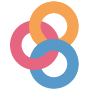">
    </a>
    <br/>
</p>

<p align="left">
    <a href="https://w3id.org/ro-id/94486a7f-e046-461f-bbb9-334ec7b57040">
        <img alt="RoHub" src="https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue">
    </a>
    <a href="https://zenodo.org/badge/latestdoi/493595755">
        <img alt="doi" src="https://zenodo.org/badge/493595755.svg">
    </a>
</p>


## Context
### Purpose
Accurately delineating trees using `detectron2`, a library that provides state-of-the-art deep learning detection and segmentation algorithms.

### Modelling approach
An established deep learning model, **Mask R-CNN** was deployed from `detectron2` library to delineate tree crowns accurately. A pre-trained model, named `detectreeRGB`, is provided to predict the location and extent of tree crowns from a top-down RGB image, captured by drone, aircraft or satellite. `detectreeRGB` was implemented in `python` 3.8 using `pytorch` v1.7.1 and `detectron2` v0.5. Further details can be found in the [repository documentation](https://github.com/shmh40/detectreeRGB).

### Highlights
* [detectreeRGB](https://github.com/shmh40/detectreeRGB) advances the state-of-the-art in tree identification from RGB images by delineating exactly the extent of the tree crown.
* We demonstrate how to apply the pretrained model to a sample image fetched from a Zenodo repository.
* Our pre-trained model was developed using aircraft images of tropical forests in Malaysia.
* The model can be further trained using the user's own images.

### Contributions

#### Notebook
* Sebastian H. M. Hickman (author), University of Cambridge, [@shmh40](https://github.com/shmh40)
* Alejandro Coca-Castro (reviewer), The Alan Turing Institute, [@acocac](https://github.com/acocac)

#### Modelling codebase
* Sebastian H. M. Hickman (author), University of Cambridge [@shmh40](https://github.com/shmh40)
* James G. C. Ball (contributor), University of Cambridge [@PatBall1](https://github.com/PatBall1)
* David A. Coomes (contributor), University of Cambridge
* Toby Jackson (contributor), University of Cambridge

#### Modelling funding
The project was supported by the UKRI Centre for Doctoral Training in Application of Artificial Intelligence to the study of Environmental Risks ([AI4ER](https://ai4er-cdt.esc.cam.ac.uk/)) (EP/S022961/1).

:::{note}
The authors acknowledge the authors of the [Detectron2](https://github.com/facebookresearch/detectron2) package which provides the Mask R-CNN architecture.
:::

## Install and load libraries

In [1]:
!pip -q install git+https://github.com/facebookresearch/detectron2.git

In [2]:
import cv2
from PIL import Image
import os
import numpy as np
import urllib.request
import glob

# intake library and plugin
import intake

# geospatial libraries
import geopandas as gpd

from rasterio.transform import from_origin
import rasterio.features

import fiona

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon

# machine learning libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer

# visualisation
import holoviews as hv
import geoviews.tile_sources as gts
import matplotlib.pyplot as plt

import hvplot.pandas
import hvplot.xarray

import pooch

import warnings
warnings.filterwarnings(action='ignore')

hv.extension('bokeh', width=100)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/utils.py:365: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


## Set folder structure

In [3]:
# Define the project main folder
notebook_folder = './notebook'

# Set the folder structure
config = {
    'in_geotiff': os.path.join(notebook_folder, 'input','tiff'),
    'in_png': os.path.join(notebook_folder, 'input','png'),
    'model': os.path.join(notebook_folder, 'model'),
    'out_geotiff': os.path.join(notebook_folder, 'output','raster'),
    'out_shapefile': os.path.join(notebook_folder, 'output','vector'),
}

# List comprehension for the folder structure code
[os.makedirs(val) for key, val in config.items() if not os.path.exists(val)]

[None, None, None, None, None]

## Load and prepare input image

### Fetch a GeoTIFF file of aerial forest imagery using `pooch`

Let's fetch a sample aerial image from a [Zenodo repository](https://zenodo.org/record/5494629#.YWQQetnMKjA).

In [4]:
pooch.retrieve(
    url="doi:10.5281/zenodo.5494629/Sep_2014_RGB_602500_646600.tif",
    known_hash="md5:77a3b57f5f5946504ec520d1e793f250",
    path=notebook_folder,
    fname="input/tiff/Sep_2014_RGB_602500_646600.tif"
)

'/home/jovyan/notebook/input/tiff/Sep_2014_RGB_602500_646600.tif'

In [5]:
# set catalogue location
catalog_file = os.path.join(notebook_folder, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  sepilok_rgb:
    driver: rasterio
    description: 'NERC RGB images of Sepilok, Sabah, Malaysia (collection)'
    args:
      urlpath: "notebook/input/tiff/Sep_2014_RGB_602500_646600.tif"
      ''')

In [6]:
cat_tc = intake.open_catalog(catalog_file)

In [7]:
tc_rgb = cat_tc["sepilok_rgb"].to_dask()

### Inspect the aerial image

Let's investigate the `data-array`, what is the shape? Bounds? Bands? CRS?

In [8]:
print('shape =', tc_rgb.shape,',', 'and number of bands =', tc_rgb.count)

shape = (4, 1400, 1400) , and number of bands = <bound method DataArrayAggregations.count of <xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535.    , ..., 65535.    , 65535.   

### Save the RGB bands of the GeoTIFF file as a PNG

**Mask R-CNN** requires images in `png` format. Let's export the RGB bands to a `png` file.

In [9]:
minx = 602500
miny = 646600

R = tc_rgb[0]
G = tc_rgb[1]
B = tc_rgb[2]
    
# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2

# you will have to change the rescaling depending on the values of your tiff!
rgb = np.dstack((R,G,B)) # BGR for cv2
rgb_rescaled = 255*rgb/65535 # scale to image
    
# save this as png, named with the origin of the specific tile - change the filepath!
filepath = config['in_png'] + '/' + 'tile_' + str(minx) + '_' + str(miny) + '.png'
cv2.imwrite(filepath, rgb_rescaled)

True

### Read in and display the PNG file

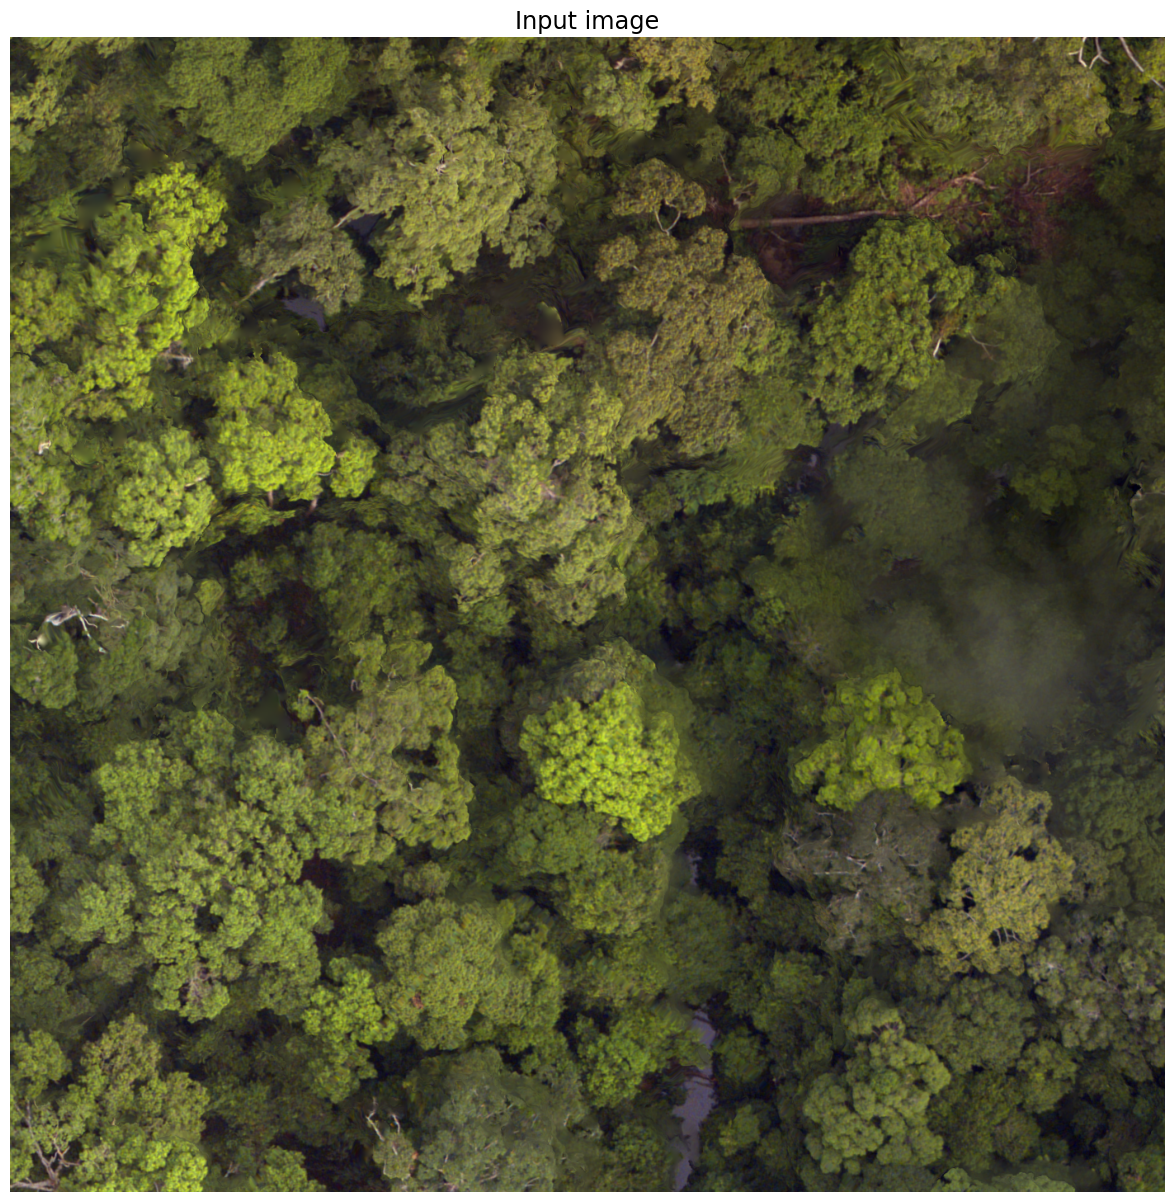

In [10]:
im = cv2.imread(filepath)
plot_input = plt.figure(figsize=(15,15))
plt.imshow(Image.fromarray(im))
plt.title('Input image',fontsize='xx-large')
plt.axis('off')
plt.show()

## Modelling

### Download the pretrained model

In [11]:
# define the URL to retrieve the model
fn = 'model_final.pth'
url = f'https://zenodo.org/record/5515408/files/{fn}?download=1'

urllib.request.urlretrieve(url, config['model'] + '/' + fn)

('./notebook/model/model_final.pth',
 <http.client.HTTPMessage at 0x7fc1e9303400>)

### Settings of `detectron2` config

The following lines allow configuring the main settings for predictions and load them into a `DefaultPredictor` object.

In [12]:
cfg = get_cfg()

# if you want to make predictions using a CPU, run the following line. If using GPU, hash it out.
cfg.MODEL.DEVICE='cpu'

# model and hyperparameter selection
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

### path to the saved pre-trained model weights
cfg.MODEL.WEIGHTS = config['model'] + '/model_final.pth'

# set confidence threshold at which we predict
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15

#### Settings for predictions using detectron config

predictor = DefaultPredictor(cfg)

## Outputs

### Showing the predictions from `detectreeRGB`

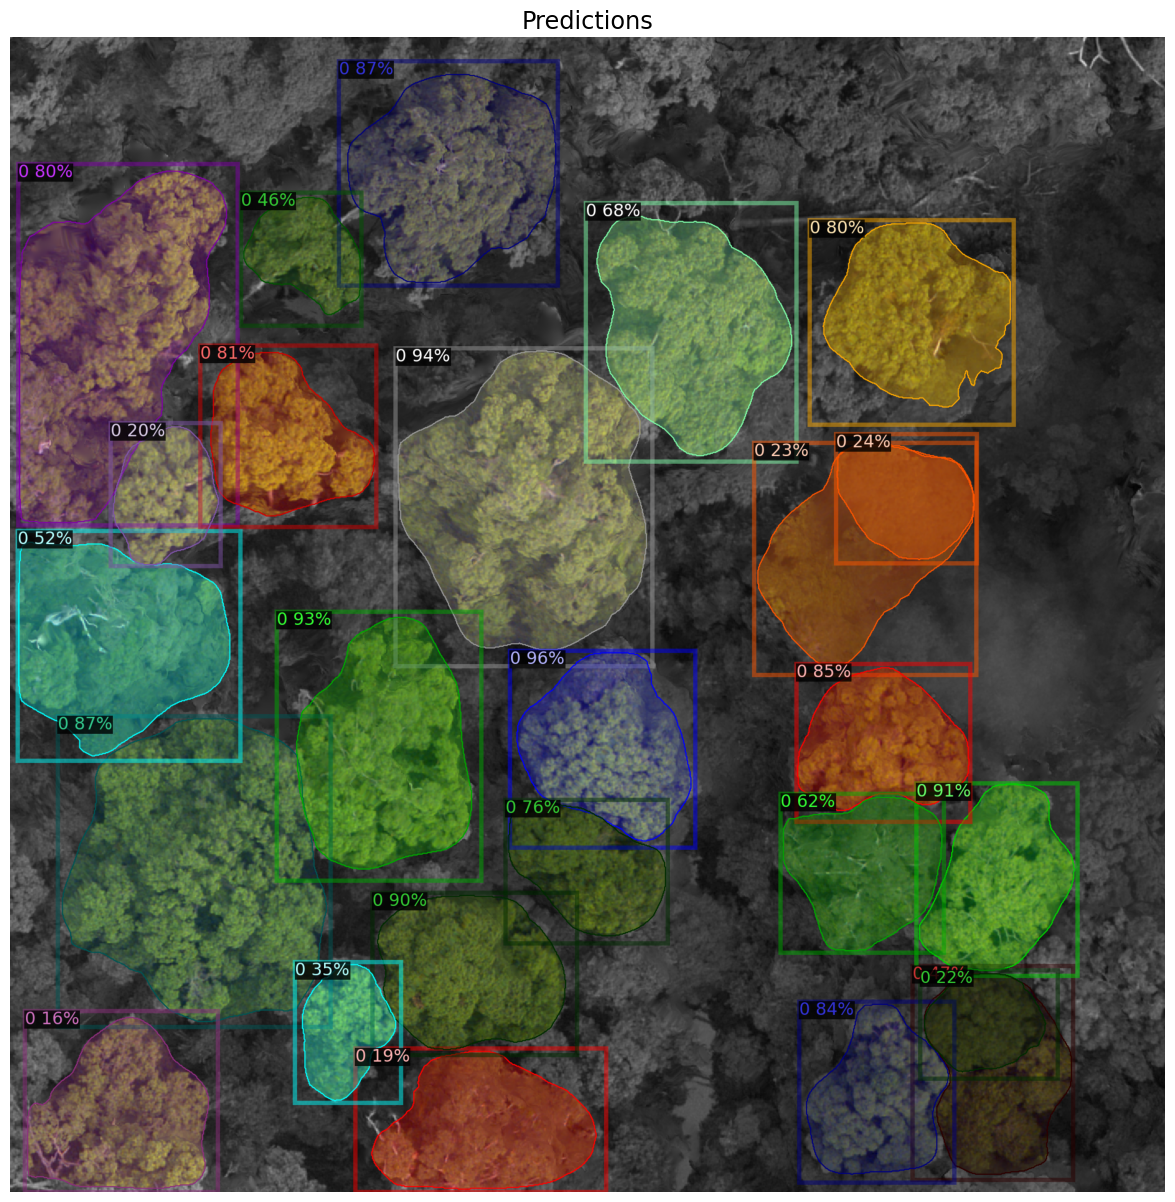

In [13]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=1.5, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(v.get_image()[:, :, :], cv2.COLOR_BGR2RGB)

plot_predictions = plt.figure(figsize=(15,15))
plt.imshow(Image.fromarray(image))
plt.title('Predictions',fontsize='xx-large')
plt.axis('off')
plt.show()

### Convert predictions into geospatial files

#### To GeoTIFF

In [14]:
mask_array = outputs['instances'].pred_masks.cpu().numpy()

# get confidence scores too 
mask_array_scores = outputs['instances'].scores.cpu().numpy()

num_instances = mask_array.shape[0]
mask_array_instance = []
output = np.zeros_like(mask_array) 

mask_array_instance.append(mask_array)
output = np.where(mask_array_instance[0] == True, 255, output)
fresh_output = output.astype(float)
x_scaling = 140/fresh_output.shape[1]
y_scaling = 140/fresh_output.shape[2]
# this is an affine transform. This needs to be altered significantly.
transform = from_origin(int(filepath[-17:-11])-20, int(filepath[-10:-4])+120, y_scaling, x_scaling)

output_raster = config['out_geotiff'] + '/' + 'predicted_rasters_' + filepath[-17:-4]+ '.tif'

new_dataset = rasterio.open(output_raster, 'w', driver='GTiff',
                                height = fresh_output.shape[1], width = fresh_output.shape[2], count = fresh_output.shape[0],
                                dtype=str(fresh_output.dtype),
                                crs='+proj=utm +zone=50 +datum=WGS84 +units=m +no_defs',  
                                transform=transform)

new_dataset.write(fresh_output)
new_dataset.close()

#### To shapefile

In [15]:
# Read input band with Rasterio
    
with rasterio.open(output_raster) as src:
    shp_schema = {'geometry': 'MultiPolygon','properties': {'pixelvalue': 'int', 'score': 'float'}}    

    crs = src.crs
    for i in range(src.count):
        src_band = src.read(i+1)
        src_band = np.float32(src_band)
        conf = mask_array_scores[i]
        # Keep track of unique pixel values in the input band
        unique_values = np.unique(src_band)
        # Polygonize with Rasterio. `shapes()` returns an iterable
        # of (geom, value) as tuples
        shapes = list(rasterio.features.shapes(src_band, transform=src.transform))

        if i == 0:
            with fiona.open(config['out_shapefile'] + '/predicted_polygons_' + filepath[-17:-4] + '_' + str(0) + '.shp', 'w', 'ESRI Shapefile',
                            shp_schema) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })
        else:
            with fiona.open(config['out_shapefile'] + '/predicted_polygons_' + filepath[-17:-4] + '_' + str(0)+'.shp', 'a', 'ESRI Shapefile',
                            shp_schema) as shp:
                polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                multipolygon = MultiPolygon(polygons)
                        # simplify not needed here
                        #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                shp.write({
                          'geometry': mapping(multipolygon),
                          'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                           })

## Interactive map to visualise the exported files

### Plot tree crown delineation predictions and scores

In [16]:
# load and plot polygons
in_shp = glob.glob(config['out_shapefile'] + '/*.shp')

poly_df = gpd.read_file(in_shp[0])

plot_vector = poly_df.hvplot(hover_cols=['score'], legend=False).opts(fill_color=None,line_color=None,alpha=0.5, width=800, height=600, xaxis=None, yaxis=None)
plot_vector

:Polygons   [x,y]   (score)

### Plot the exported GeoTIFF file

In [17]:
# load and plot RGB image
r = tc_rgb.sel(band=[1,2,3])

normalized = r/(r.quantile(.99,skipna=True)/255)

mask = normalized.where(normalized < 255)

int_arr = mask.astype(int)

plot_rgb = int_arr.astype('uint8').hvplot.rgb(
    x='x', y='y', bands='band', data_aspect=0.8, hover=False, legend=False, rasterize=True, xaxis=None, yaxis=None, title='Tree crown delineation by detectreeRGB'
)

### Overlay the prediction labels and image

Note we have some artifacts in the RGB image due to the transformations using the normalization procedure.

In [18]:
plot_predictions_interactive = plot_rgb * plot_vector
plot_predictions_interactive

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


:DynamicMap   []
   :Overlay
      .RGB.I      :RGB   [x,y]   (R,G,B)
      .Polygons.I :Polygons   [x,y]   (score)

### Save plot

In [19]:
hvplot.save(plot_predictions_interactive, notebook_folder + '/interactive_predictions.html')

## Summary

We have read in a raster, chosen a tile and made predictions on it. These predictions can then be transformed to shapefiles and examined in GIS software!

* We made the predictions on the `png` using a pretrained **Mask R-CNN** model, `detectreeRGB`.
* The outputs showed the model capability to detect and delineate tree crowns from aerial imagery.
* We then extracted our predictions, added the geospatial location back in, and exported them as shapefiles including the confidence score assigned to each prediction by the model.
* Visualised the predictions on an interactive map!

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book-gallery/94486a7f-e046-461f-bbb9-334ec7b57040/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information
**Codebase**: version 1.0.0 with commit <mark>[16a5a1c](https://github.com/shmh40/detectreeRGB/compare/main...dev)</mark>

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [20]:
from datetime import date

print('Notebook repository version: v1.0.4')
print(f'Last tested: {date.today()}')

Notebook repository version: v1.0.4
Last tested: 2024-03-12


## Outputs registration
The cell below is dedicated to save the notebook outputs for registering them into a Zenodo repository curated by the Environmental DS book.

In [21]:
outputs = {
    'static_figures': {
        'filenames': ['static_input','static_predictions'],
        'data':[plot_input, plot_predictions]},
    'interactive_figures': {
        'filenames': ['interactive_vector','interactive_predictions'],
        'data':[plot_vector, plot_predictions_interactive]},
}

#save static figures
if len(outputs['static_figures']['filenames']) > 0:
    [data.savefig(os.path.join(notebook_folder,outputs['static_figures']['filenames'][x]  + '.png')) for x, data in enumerate(outputs['static_figures']['data'])]

#save interactive figures
if len(outputs['interactive_figures']['filenames']) > 0:
    [hvplot.save(data, os.path.join(notebook_folder,outputs['interactive_figures']['filenames'][x]  + '.html')) for x, data in enumerate(outputs['interactive_figures']['data'])]